# Загрузка датасета

Импорт необходимых библиотек

In [1]:
import pickle
import os

from PIL import Image
import math
import torchvision
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from livelossplot import PlotLossesKeras

### Напишем всю основную структуру для дальнейшей работы

1. Прочитаем pikcle-файлы

In [2]:
def open_f(filename, back=1):
    filepath = os.path.join('..\\' * back, 'data', filename)
    with open(filepath, 'rb') as f:
        return pickle.load(f)

labels = open_f('meta', 2)
data_all = open_f('data_train', 2)
data_test = open_f('data_test', 2)

2. Определим трейновые картинки и ответы в переменные и перемешаем их

In [3]:
shuffle = np.random.permutation(data_all['images'].shape[0])
train_images_full, train_labels_full = data_all['images'][shuffle], data_all['labels'][shuffle].ravel()

3. Разобьем датасет на трейновый и валидационный

In [4]:
val_size = 0.05

train_ds_x, val_ds_x, train_ds_y, val_ds_y = train_test_split(train_images_full, train_labels_full, test_size=val_size)

4. Класс DataSequence - класс для создания аугментационного датасета

In [5]:
class DataSequence(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, transform=None, batch_size=512):
        shuffle = np.random.permutation(y_set.shape[0])
        # список индексов для shuffle
        self.x = x_set[shuffle]
        self.y = y_set[shuffle]
        self.transform = transform
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.y.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        shuffle = np.random.permutation(batch_x.shape[0])
        batch_x, batch_y = batch_x[shuffle], batch_y[shuffle]
        # если self.transform - это одна аугментация
        if type(self.transform) is torchvision.transforms.Compose:
            return (
                np.array([np.asarray(self.transform(Image.fromarray(np.uint8(x)))) / 255. for x in batch_x]),
                batch_y
            )
        # если self.transform - это список различных аугментаций
        elif type(self.transform) is list:
            trans = np.random.choice(self.transform)
            # применяем рандомную аугментацию каждому изображению из батча
            return (
                np.array([np.asarray(trans(Image.fromarray(np.uint8(x)))) / 255. for x in batch_x]),
                batch_y
            )
        return batch_x / 255, batch_y

### Для примера создадим объекты нового класса и визуализируем

In [6]:
transform = [
    torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=(0, 50))]),

    torchvision.transforms.Compose([
    torchvision.transforms.RandomInvert(1),
    torchvision.transforms.RandomAffine(4)]), 

    torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3)])
]

ds_visuation = DataSequence(train_ds_x, train_ds_y, batch_size=9)
ds_aug_visuation = DataSequence(train_ds_x, train_ds_y, transform, batch_size=9)

Нарисуем несколько изображений без аугментации с использованием нашего класса

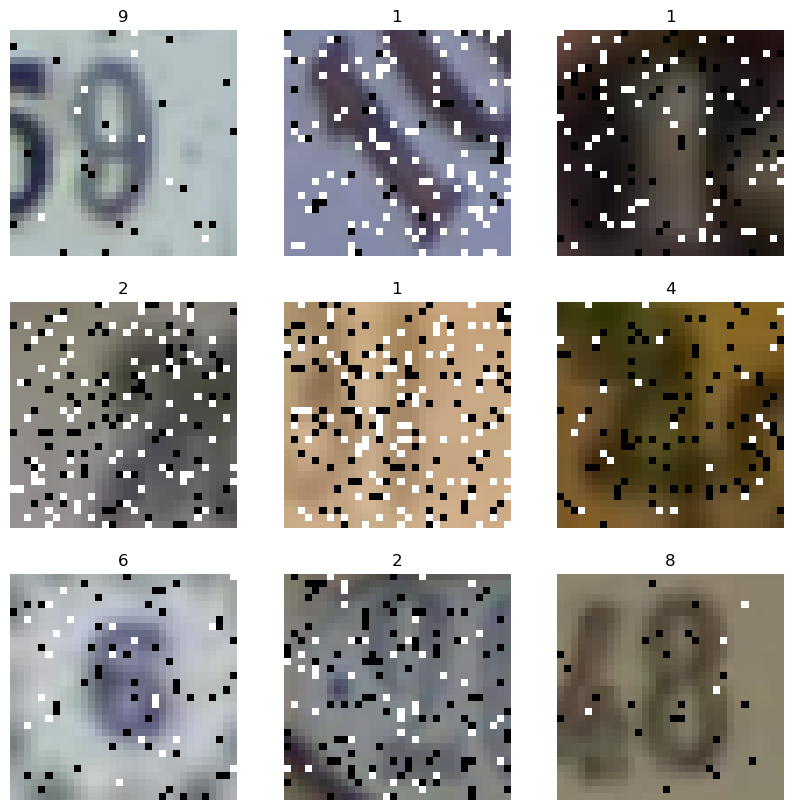

In [7]:
plt.figure(figsize=(10, 10))
images, labels = ds_visuation[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.title(labels[i])
    plt.axis('off')

Нарисуем несколько изображений с аугментацией с использованием нашего класса

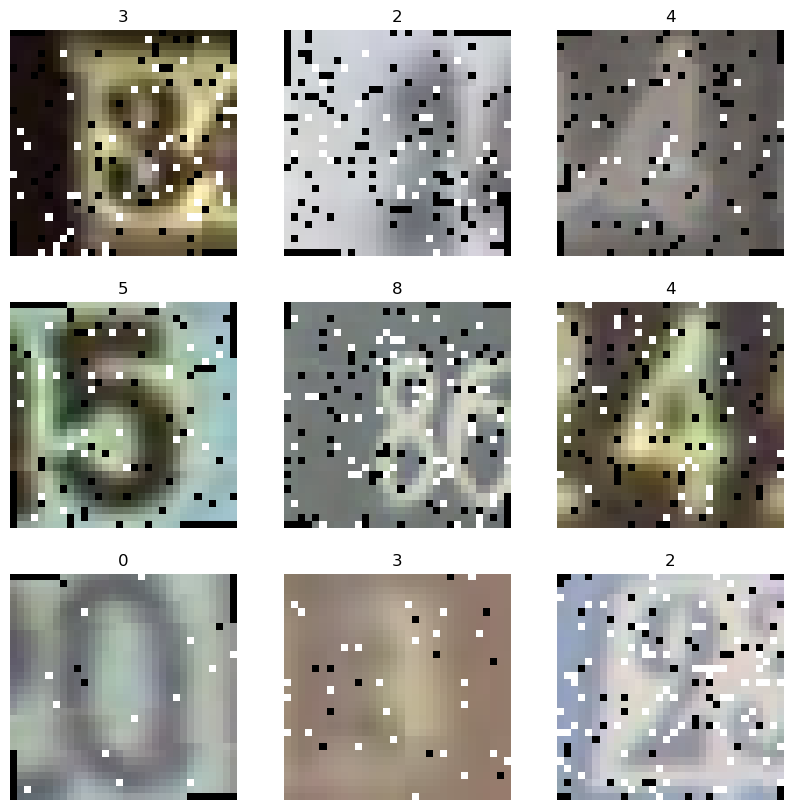

In [8]:
plt.figure(figsize=(10, 10))
images, labels = ds_aug_visuation[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.title(labels[i])
    plt.axis('off')

### Проверим работу на модели


1. Создаем трейновый датасет с аугментацией

In [9]:
batch_size = 256
aug_train_ds = DataSequence(train_ds_x, train_ds_y, transform, batch_size=batch_size)

2. Формируем валидационный датасет

In [10]:
val_ds = tf.data.Dataset.from_tensor_slices((val_ds_x, val_ds_y))
val_ds = val_ds.batch(batch_size)

3. Напишем модель для проверки работы класса

In [11]:
model = tf.keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),          
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.05), 
    layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                        

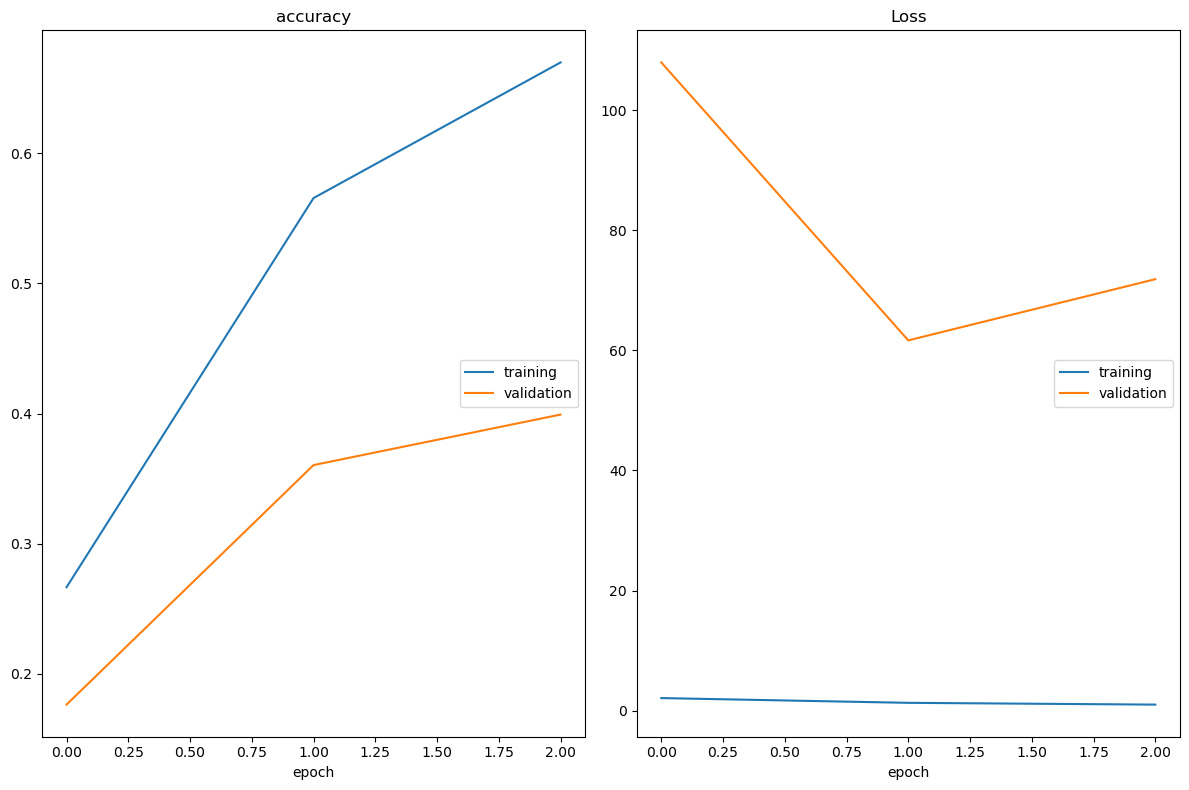

accuracy
	training         	 (min:    0.267, max:    0.670, cur:    0.670)
	validation       	 (min:    0.176, max:    0.399, cur:    0.399)
Loss
	training         	 (min:    1.026, max:    2.114, cur:    1.026)
	validation       	 (min:   61.661, max:  107.926, cur:   71.844)


In [14]:
model.compile(
      optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=['accuracy'])

history = model.fit(aug_train_ds, validation_data=val_ds, epochs=3,
              callbacks=[PlotLossesKeras()], verbose=False)

**Вывод**: Все работает. Перепишем этот код в файл `core/datasets.py`, чтобы в дальнейшем можно было легко импортировать написанный класс в любой файл.